In [1]:
import os
import re
import pickle
import time
import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


from scipy.sparse import csr_matrix

%matplotlib inline

# Custom modules
import const
import func

## Load data

In [91]:
# Load look-up table
lut = pd.read_csv(const.LOOK_UP_TABLE)
lut.head()

,line,station,feature_nr,feat_nr_dat,name_dat,name_cat,name_num,station_V2
0,0,0,0,1.0,L0_S0_D1,NaN,L0_S0_F0,0.0
1,0,0,2,3.0,L0_S0_D3,NaN,L0_S0_F2,0.0
2,0,0,4,5.0,L0_S0_D5,NaN,L0_S0_F4,0.0
3,0,0,6,7.0,L0_S0_D7,NaN,L0_S0_F6,0.0
4,0,0,8,9.0,L0_S0_D9,NaN,L0_S0_F8,0.0


In [92]:
lut.station_V2.unique()

array([  0.   ,   1.   ,   2.   ,   3.   ,   4.   ,   5.   ,   6.   ,
         7.   ,   8.   ,   9.   ,  10.   ,  11.   ,  12.   ,  13.   ,
        14.   ,  15.   ,  16.   ,  17.   ,  18.   ,  19.   ,  20.   ,
        21.   ,  22.   ,  23.   ,  24.1  ,  24.101,  24.102,  24.103,
        24.104,  24.105,  24.106,  24.107,  24.108,  24.109,  24.11 ,
        24.111,  24.112,  24.2  ,  24.201,  24.202,  24.203,  24.204,
        24.205,  24.206,  24.207,  24.208,  24.209,  24.21 ,  24.211,
        24.3  ,  24.301,  24.302,  24.303,  24.304,  24.305,  24.306,
        24.307,  24.308,  24.309,  24.31 ,  24.311,  25.1  ,  25.101,
        25.102,  25.103,  25.104,  25.105,  25.106,  25.107,  25.108,
        25.109,  25.11 ,  25.2  ,  25.201,  25.202,  25.203,  25.204,
        25.205,  25.206,  25.207,  25.208,  25.209,  25.21 ,  25.211,
        25.212,  25.213,  25.214,  25.215,  25.216,  25.217,  25.218,
        25.219,  25.22 ,  25.221,  25.222,  25.223,  25.224,  25.225,
        25.226,  25.

In [93]:
# Load unique paths and covert them to dataframe
paths = pd.read_csv(os.path.join(const.DATA_PATH, 'eda_product_flow_unique_paths_station.csv'), index_col=0)

# Convert strings to int array (could not find a way to split the characters in string other than this...)
paths = (paths.u_str.str.replace('0','0,').str.replace('1','1,').str.split(',')).apply(pd.Series)

# Drop last column (residue after split)
paths.drop(paths.columns[-1], axis=1, inplace=True)

# To ints
paths = paths.astype(int)

# Replace index by station_V2 numbers
paths.columns = lut.groupby('station_V2').station_V2.first().reset_index(drop=True).values

paths.head(3)

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0,50.0,51.0
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,1,0,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,1,1


In [94]:
paths.shape

(15210, 129)

In [95]:
# Load unique path per sample ID
string_id_to_pid = pd.read_csv(os.path.join(const.DATA_PATH, 'eda_product_flow_sample_paths_station.csv'))

In [96]:
string_id_to_pid.head(3)

,id,u_arr_ix
0,4,13409
1,6,7029
2,7,12763


In [97]:
# Load response
y=func.read_last_column('train_numeric.csv')#[:500000]
y.head(3)

,Response
Id,
4,0
6,0
7,0


## Calculate clusters

In [9]:
from sklearn.cluster import KMeans

In [10]:
nclus = 100
km = KMeans(nclus, n_init=100, max_iter=100, random_state=11111)

In [11]:
km.fit(paths)

KMeans(copy_x=True, init='k-means++', max_iter=100, n_clusters=100,
    n_init=100, n_jobs=1, precompute_distances='auto', random_state=11111,
    tol=0.0001, verbose=0)

In [12]:
km.predict(paths)

array([ 1, 39, 39, ..., 97, 22, 97], dtype=int32)

In [13]:
km.predict(paths).shape

(15210,)

In [14]:
clusters = pd.DataFrame(pd.Series(km.labels_), index=paths.index, columns=['cluster'])

In [15]:
clusters.head(3)

,cluster
id,
0,1
1,39
2,39


In [109]:
def cluster_unique_paths(unique_paths, n_clus):
    ''' Function to cluster set of unique paths '''
    
    # Cluster using Kmeans
    km = KMeans(n_clus, n_init=100, max_iter=100, random_state=11111)
    km.fit(unique_paths)
    
    # Return DataFrame
    clusters = pd.DataFrame(pd.Series(km.labels_), 
                            index=unique_paths.index, 
                            columns=['cluster'])
    
    return clusters

def visualize_cluster_result(unique_paths, clusters, sample_to_path, y):
    
    nclus = clusters['cluster'].nunique()
    
    if 'id' in sample_to_path.columns:
        sample_to_path.set_index('id')
    
    cluster_per_sample = sample_to_path.merge(unique_paths, 
                                   left_on='u_arr_ix', 
                                   right_index=True, 
                                   how='left') \
                            .merge(clusters,
                                   left_on='u_arr_ix',
                                   right_index=True,
                                   how='left') \
                            .drop(['u_arr_ix'], axis=1) \
                            .set_index('id')
    
    
    cluster_grouped = cluster_per_sample.groupby('cluster').mean()
    # Fix weird rounding bug
    cluster_grouped.columns = [round(n,3) for n in cluster_grouped.columns]
    
                    
    # Get sorting index based on major thresholds
    try:
        so = (cluster_grouped>0.85).sort_values([0.0, 12.0, 24.1, 24.2, 24.3, 25.1, 25.202, 25.212, 25.222, 26.0, 27.0])
    except:
        print('Error sorting values')
        so = (cluster_grouped>0.85)
    
    
    # Visualize major stations per cluster
    plt.figure(figsize=(16,6))
    gs = gridspec.GridSpec(1, 3,width_ratios=[5,1,1])

    ax2 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax3 = plt.subplot(gs[2])


    ax1.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='on',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on',
        labelleft='off') # labels along the bottom edge are off
    ax2.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off',
        labelleft='on') # labels along the bottom edge are off
    ax3.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='on',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on',
        labelleft='off') # labels along the bottom edge are off
    
    sns.heatmap(cluster_per_sample.groupby('cluster').mean().loc[so.index,:], cmap='Blues', ax=ax2, cbar=False)
    ax2.set_title('Number of clusters: {}'.format(nclus))
    
    cluster_per_sample['R'] = y
    
    # Create dataframe with results
    cluster_summary = pd.DataFrame({'meanR': cluster_per_sample.groupby('cluster').R.mean(),
                                'sample_count': cluster_per_sample.groupby('cluster').R.count()},
                               index=range(nclus))
    cluster_summary.sort_values('sample_count', ascending=False, inplace=True)
    
    # Plot error rates (trick to plot from right to left)
    (cluster_summary['meanR']*100).loc[so.index[::-1]].plot(kind='barh', ax=ax1)

    labs = [1*x for x in ax1.get_xticks().tolist()]
    ax1.set_xticklabels(labs, rotation='vertical')
    ax1.set_xlabel('Error rate (%)')
    ax1.set_xlim([0, ax1.get_xlim()[1]])
    ax1.set_ylabel('')
    
    # Plot sample count
    cluster_summary['sample_count'].loc[so.index[::-1]].apply(lambda x: np.log10(x)).plot(kind='barh', ax=ax3)
    ax3.set_xlabel('log10(Sample count)')
    ax3.set_ylabel('')
    
    plt.tight_layout()
    
    return cluster_summary

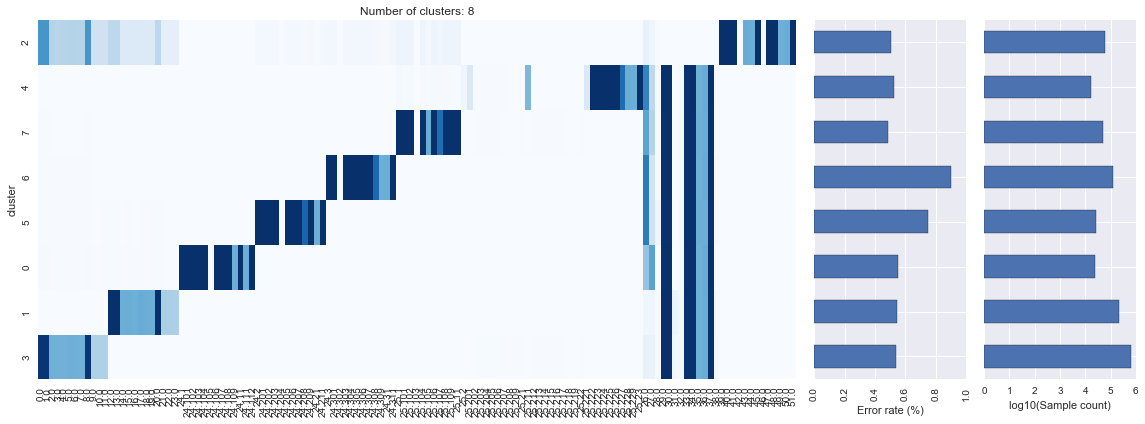

In [110]:
clusters_8 = cluster_unique_paths(paths, 8)
summary_8 = visualize_cluster_result(paths, clusters_8, string_id_to_pid, y)

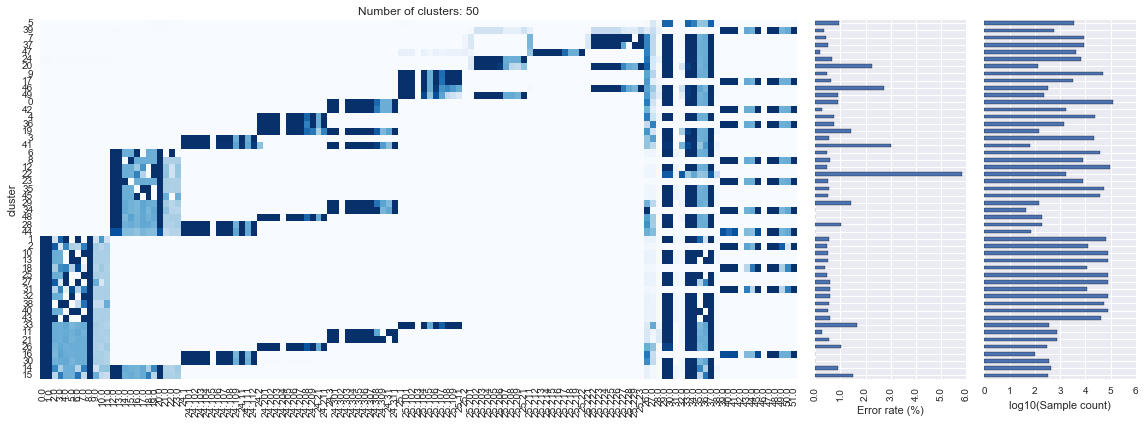

In [111]:
clusters_50 = cluster_unique_paths(paths, 50)
summary_50 = visualize_cluster_result(paths, clusters_50, string_id_to_pid, y)

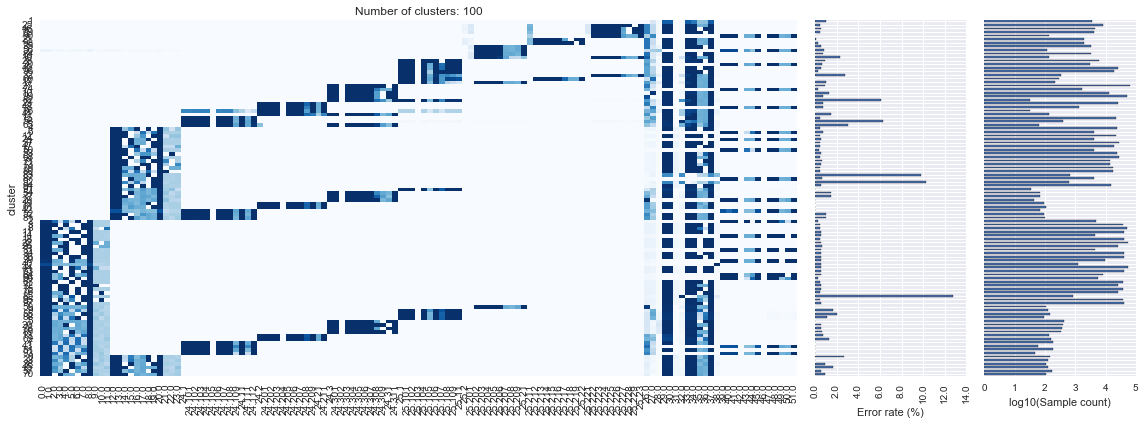

In [112]:
clusters_100 = cluster_unique_paths(paths, 100)
summary_100 = visualize_cluster_result(paths, clusters_100, string_id_to_pid, y)

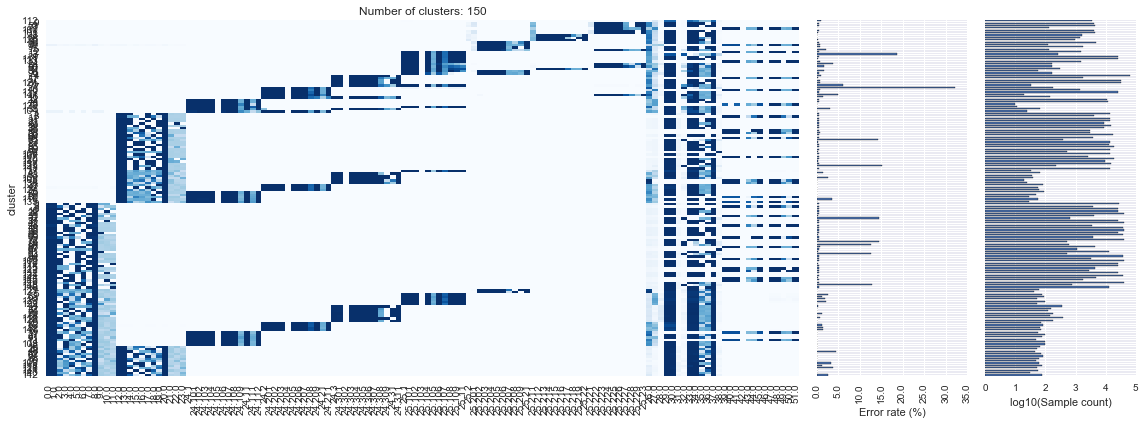

In [ ]:
clusters_150 = cluster_unique_paths(paths, 150)
summary_150 = visualize_cluster_result(paths, clusters_150, string_id_to_pid, y)

In [ ]:
clusters_500 = cluster_unique_paths(paths, 500)
summary_500 = visualize_cluster_result(paths, clusters_500, string_id_to_pid, y)

In [612]:
pid_to_cluster = string_id_to_pid.merge(clusters_8,
                                   left_on='u_arr_ix',
                                   right_index=True,
                                   how='left')
pid_to_cluster = pid_to_cluster.merge(clusters_50,
                                   left_on='u_arr_ix',
                                   right_index=True,
                                   how='left')
pid_to_cluster = pid_to_cluster.merge(clusters_100,
                                   left_on='u_arr_ix',
                                   right_index=True,
                                   how='left') 
pid_to_cluster = pid_to_cluster.merge(clusters_500,
                                   left_on='u_arr_ix',
                                   right_index=True,
                                   how='left') 
pid_to_cluster.set_index('id', inplace=True)
pid_to_cluster.columns = ['unique_path','cluster_n8','cluster_n50', 'cluster_n100', 'cluster_n500']

In [613]:
pid_to_cluster.head(3)

,unique_path,cluster_n8,cluster_n50,cluster_n100,cluster_n500
id,,,,,
4,13409,3,25,3,127
6,7029,1,45,80,20
7,12763,3,40,11,348


In [614]:
pid_to_cluster.to_csv(os.path.join(const.DATA_PATH, 'eda_sample_clusters.csv'), index_label='Id')

### Try to cluster only line 3

In [480]:
paths.columns.get_loc(26.)

103

Error sorting values


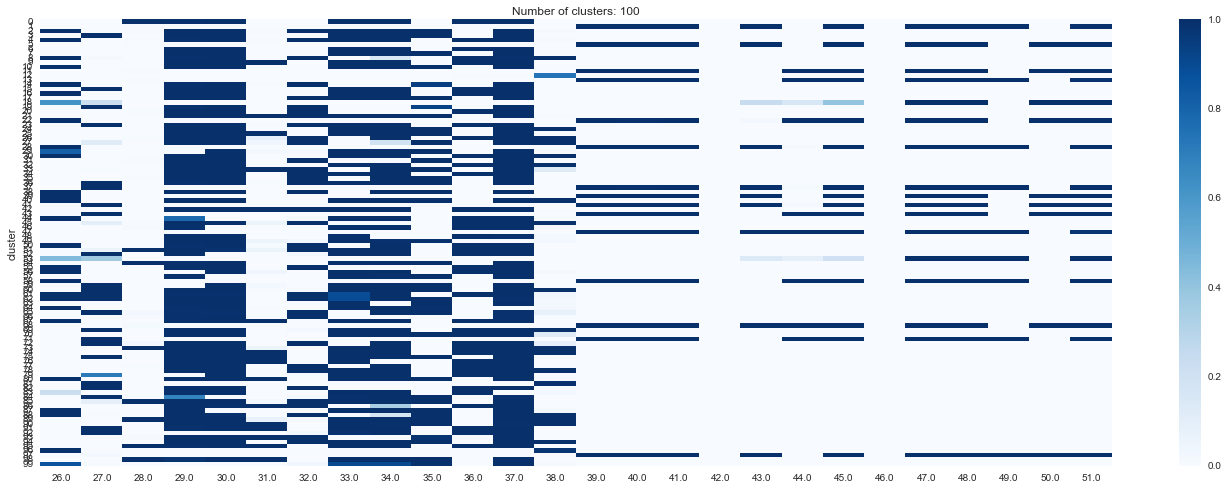

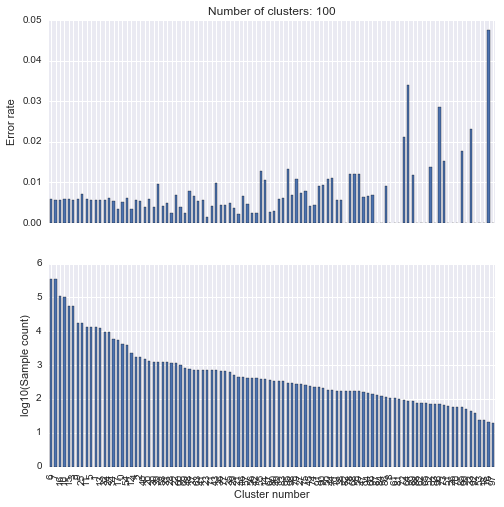

In [490]:
clusters_line_3 = cluster_unique_paths(paths.iloc[:, 103:], 100)
summary_line_3 = visualize_cluster_result(paths.iloc[:, 103:], clusters_line_3, string_id_to_pid, y)

## Experimental stuff

### Find out whether number of paths plays a role

In [150]:
pid_to_cluster = pd.read_csv(os.path.join(const.DATA_PATH, 'eda_sample_clusters.csv'), index_col=0)
pid_to_cluster['R']=y
pid_to_cluster=pid_to_cluster[~pid_to_cluster.R.isnull()]
pid_to_cluster.head(3)

,unique_path,cluster_n8,cluster_n50,cluster_n100,cluster_n500,R
Id,,,,,,
4,13409,3,25,3,127,0.0
6,7029,1,45,80,20,0.0
7,12763,3,40,11,348,0.0


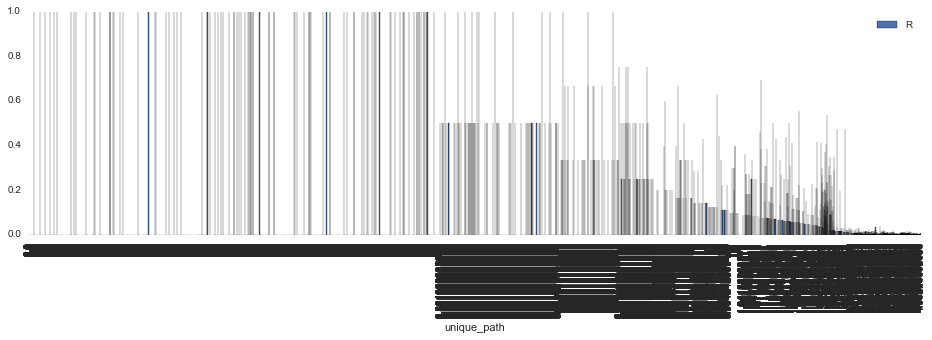

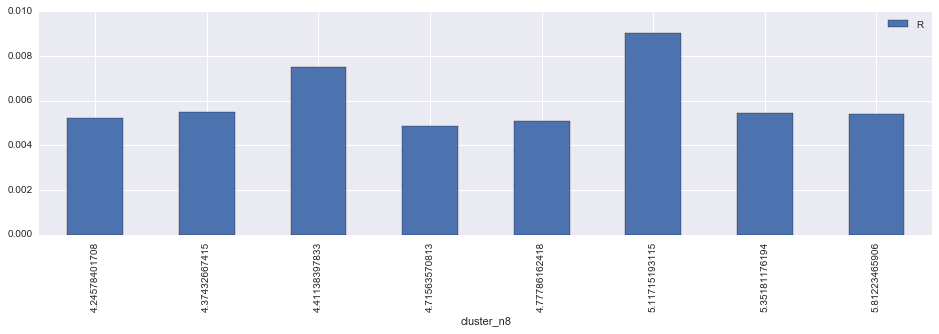

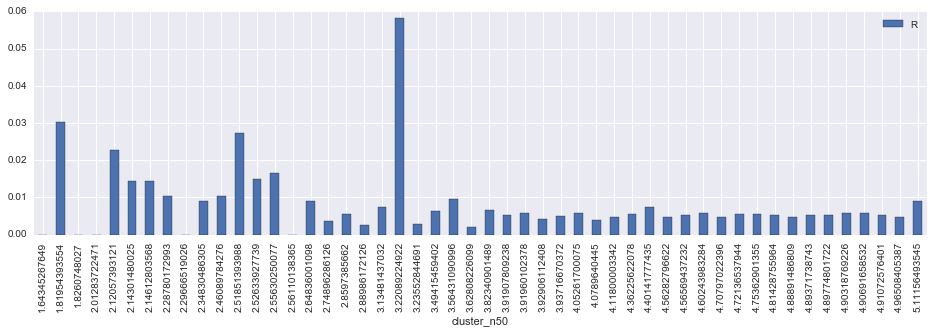

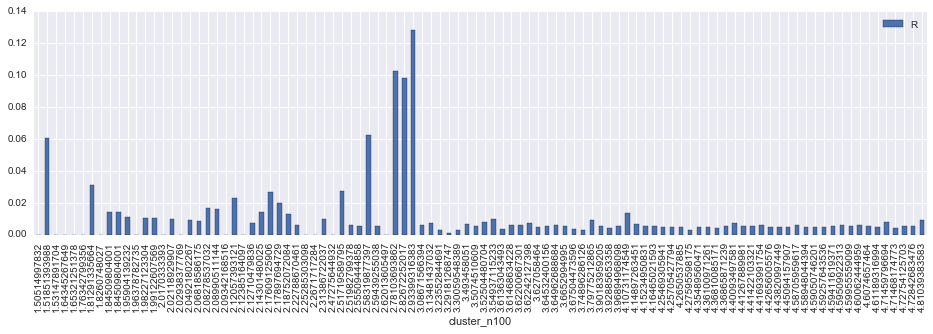

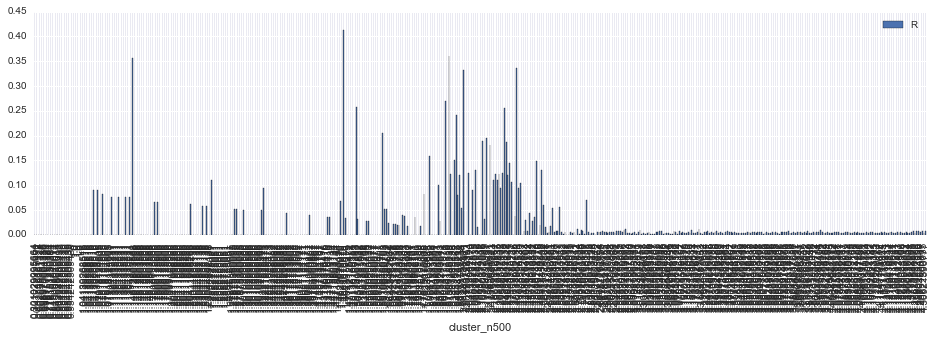

In [174]:
for col in pid_to_cluster.columns[:-1]:

    cnt_agg = pid_to_cluster.groupby(col).agg({col:'count','R':'mean'})
    cnt_agg[col] = np.log10(cnt_agg[col])
    cnt_agg.set_index(col, drop=True, inplace=True)
    cnt_agg.sort_index(inplace=True)
    plt.figure(figsize=(16,4))
    cnt_agg.plot(kind='bar', figsize=(16,4))

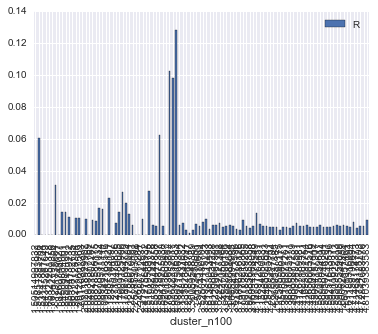

In [168]:
cnt_agg.plot(kind='bar')

### Find out what the uncommon paths have in common
Could not find specific paths or subpaths they have in common.

In [49]:
clust_high = summary_500[summary_500.meanR>0.008]
print clust_high.shape
clust_high.head(3)

(64, 2)


,meanR,sample_count
125,0.008495,4473
429,0.008213,4018
294,0.008294,1929


In [50]:
cluster_per_sample_500 = string_id_to_pid.merge(paths, 
                               left_on='u_arr_ix', 
                               right_index=True, 
                               how='left') \
                        .merge(clusters_500,
                               left_on='u_arr_ix',
                               right_index=True,
                               how='left') \
                        .drop(['u_arr_ix','id'], axis=1)

In [65]:
exa=cluster_per_sample_500[(cluster_per_sample_500.iloc[:, 12]==1) & (cluster_per_sample_500.iloc[:, 0]==1)]

In [69]:
exa_high = exa[exa.cluster.isin(clust_high.index)]
exa_low = exa[~exa.cluster.isin(clust_high.index)]

In [72]:
exa_high.head(3)

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,43.0,44.0,45.0,46.0,47.0,48.0,49.0,50.0,51.0,cluster
795,1,1,0,1,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,443
1822,1,1,0,1,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,443
5152,1,1,0,1,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,369


In [82]:
exa_high.shape

(218, 130)

In [117]:
exa_low.shape

(1317, 130)

In [138]:
n_s = 0
n_e = 12

diffs = []

for j in range(150):
    mean_high = float((exa_high.iloc[:,(n_s+j):(n_e+j)]>0).sum().sum())/218
    mean_low = float((exa_low.iloc[:,(n_s+j):(n_e+j)]>0).sum().sum())/1317
    diffs.append(np.divide(mean_high,mean_low))
    #print mean_low
    #print mean_high
    #print np.divide(mean_high,mean_low)
    #print ('')

print(max(diffs))
print(min(diffs))

1.28310465211
0.0


In [83]:
exa_low.shape

(1317, 130)

21

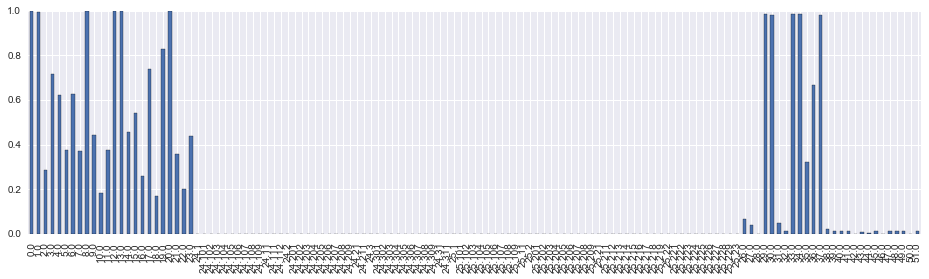

In [76]:
exa_high.mean().iloc[:-1].plot(kind='bar', figsize=(16,4))

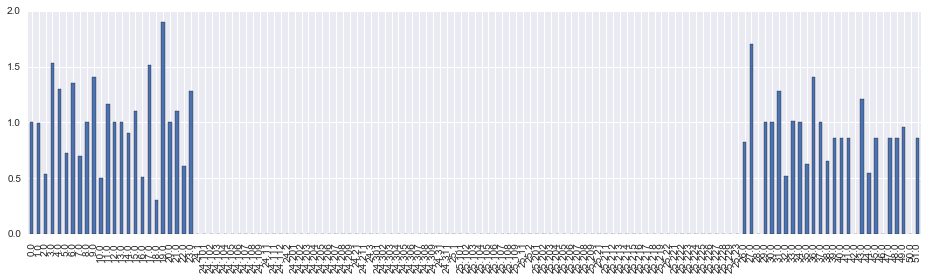

In [78]:
(exa_high.mean().iloc[:-1] / exa_low.mean().iloc[:-1]).plot(kind='bar', figsize=(16,4))

In [56]:
mean_per_cluster = cluster_per_sample_500.groupby('cluster').mean()

In [57]:
mean_per_cluster.head(3)

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0,50.0,51.0
cluster,,,,,,,,,,,,,,,,,,,,,
0,1.000000,0.990909,1.000000,0.000000,1.0,0.0,0.509091,0.490909,1.000000,0.390909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.998335,0.998631,0.998335,0.000037,0.0,1.0,0.000000,1.000000,0.998779,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
mean_per_cluster

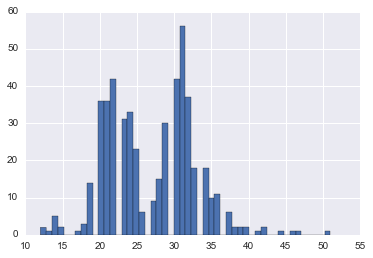

In [61]:
(mean_per_cluster>0).sum(1).hist(bins=50)

In [28]:
cluster_per_sample_100.columns

Index([       0.0,        1.0,        2.0,        3.0,        4.0,        5.0,
              6.0,        7.0,        8.0,        9.0,
       ...
             43.0,       44.0,       45.0,       46.0,       47.0,       48.0,
             49.0,       50.0,       51.0, u'cluster'],
      dtype='object', length=130)

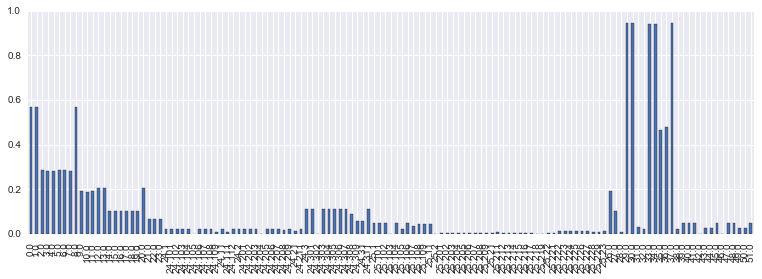

In [53]:
cluster_per_sample_500.iloc[:, :-1].mean().plot(kind='bar', figsize=(13,4))

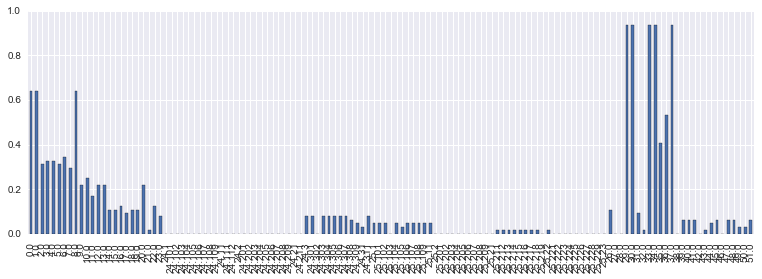

In [54]:
cluster_per_sample_500.loc[clust_high.index].iloc[:, :-1].mean().plot(kind='bar', figsize=(13,4))

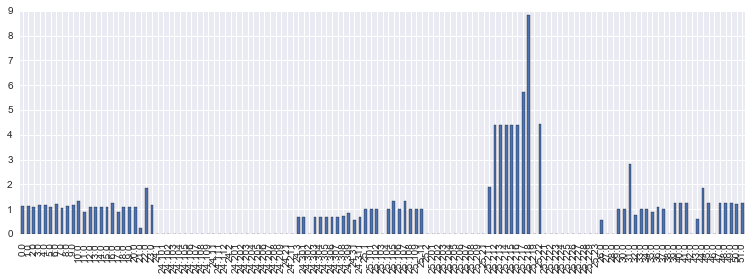

In [55]:
(cluster_per_sample_500.loc[clust_high.index].iloc[:, :-1].mean()/cluster_per_sample_500.iloc[:, :-1].mean()).plot(kind='bar', figsize=(13,4))

### Visualize cluster 3

    30.0  31.0  32.0  33.0  34.0  cluster
id                                       
4      1     1     0     1     1        4
6      1     0     0     1     1        2
7      1     0     0     1     1        2
9      1     0     0     1     1        2
11     1     0     0     1     1        2
Error sorting values


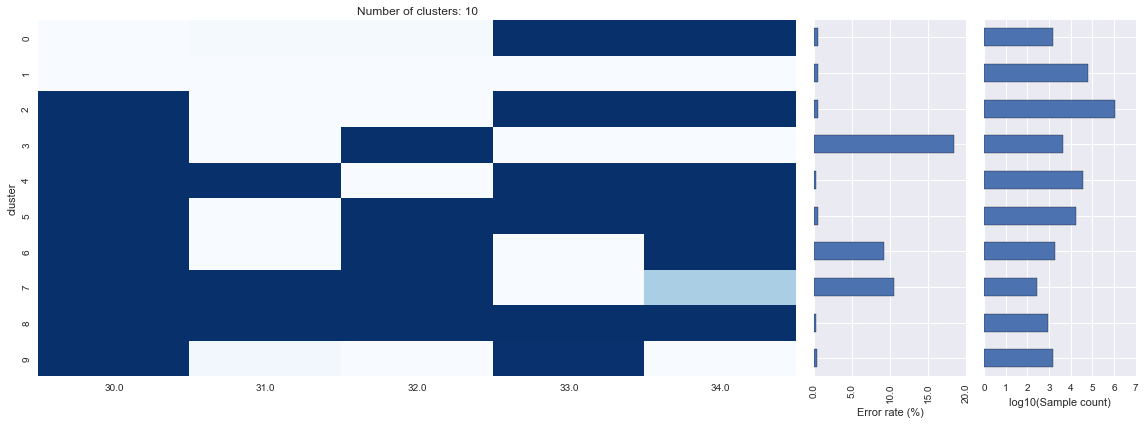

In [108]:
clusters_line_3 = cluster_unique_paths(paths.iloc[:, 107:112], 10)
summary_line_3 = visualize_cluster_result(paths.iloc[:, 107:112], clusters_line_3, string_id_to_pid, y)